In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [2]:
from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot

In [3]:
consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_4 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 0.3) for _ in range(4)]

powerball_4 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(4)]

dist_N = consistent_4 + highvar_4 +powerball_4

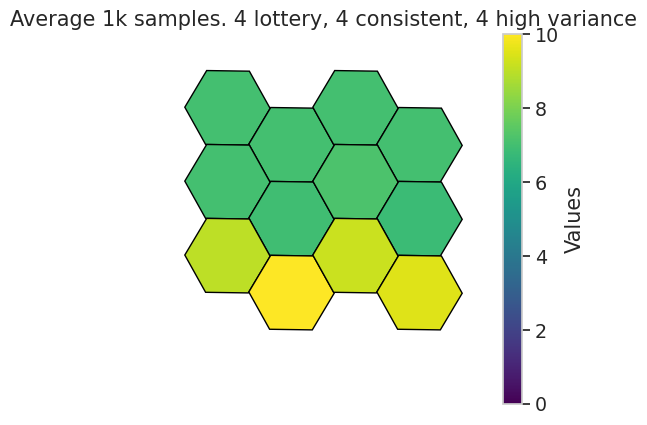

In [4]:
sample_and_plot(dist_N, size=1000, average=True, title='Average 1k samples. 4 lottery, 4 consistent, 4 high variance', vmin=0, vmax=10)

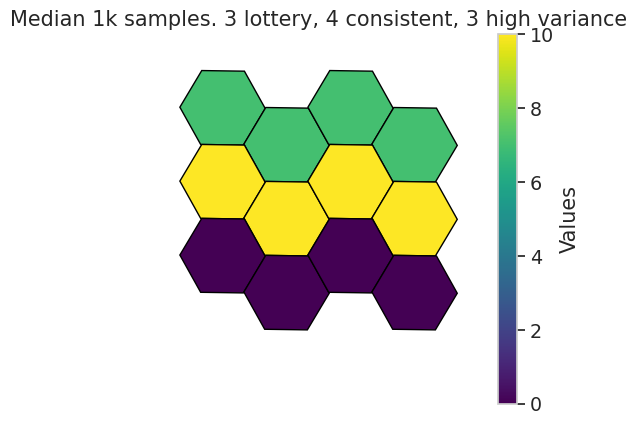

In [5]:
sample_and_plot(dist_N, size=1000, median=True, title='Median 1k samples. 3 lottery, 4 consistent, 3 high variance')

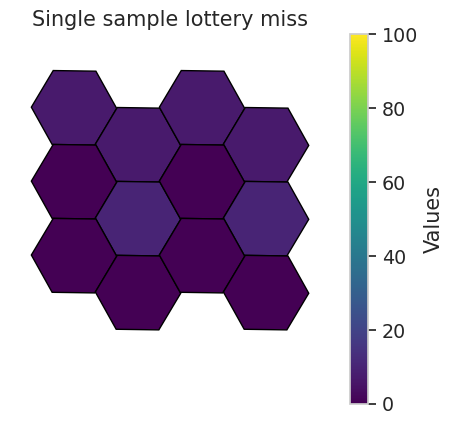

In [6]:
sample_and_plot(dist_N, size=1000, average=False, index=-1, title='Single sample lottery miss')

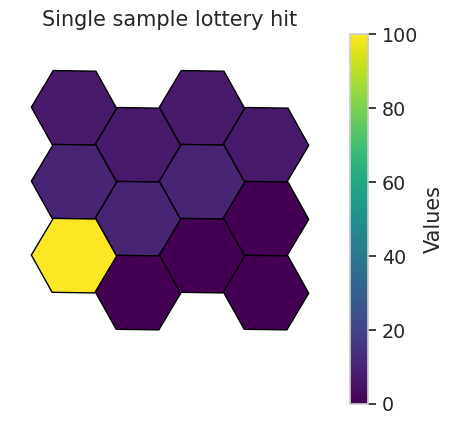

In [7]:
sample_and_plot(dist_N, size=1000, average=False, index=-6, title='Single sample lottery hit')

In [8]:
def calc_bpr_many_trials(
        dist_N, K=3, n_trials=10000, seed=101,
        strategy='pick_mean',
        percentile_as_frac=0.95):
    N = len(dist_N)
    y_RN = np.zeros((n_trials, N), dtype=np.int32)
    for n, dist in enumerate(dist_N):
        random_state = np.random.RandomState(10000 * seed + n)
        y_RN[:, n] = dist.rvs(size=n_trials, random_state=random_state)

    if strategy == 'cross_ratio':
        S = 100*n_trials
        y_SN = np.zeros((S, N))
        sum_str_N = [None for _ in range(N)]
        for n, dist in enumerate(dist_N):
            random_state = np.random.RandomState(10000 * seed + n)
            y_SN[:,n] = dist.rvs(size=S, random_state=random_state)
            sum_str_N[n] = " ".join(['%.1f' % np.percentile(y_SN[:,n], p)
                                    for p in [0, 10, 50, 90, 100]])
        ratio_N = np.mean(y_SN / np.sum(y_SN, axis=1, keepdims=1), axis=0)
        assert ratio_N.shape == (N,)
        selected_ids_K = np.argsort(-1 * ratio_N)[:K]

        selected_ids_RK = np.tile(selected_ids_K, (n_trials,1))

    if strategy == 'cross_ratio_topk':
        S = 100*n_trials
        y_SN = np.zeros((S, N))
        sum_str_N = [None for _ in range(N)]
        for n, dist in enumerate(dist_N):
            random_state = np.random.RandomState(10000 * seed + n)
            y_SN[:,n] = dist.rvs(size=S, random_state=random_state)
            sum_str_N[n] = " ".join(['%.1f' % np.percentile(y_SN[:,n], p)
                                    for p in [0, 10, 50, 90, 100]])

        topk_ids_SN = np.argsort(-1 * y_SN, axis=1)[:, :K]
        topk_y_SN = np.take_along_axis(y_SN, topk_ids_SN, axis=1)
        ratiotopk_N = np.mean(y_SN / np.sum(topk_y_SN, axis=1, keepdims=1), axis=0)
        assert ratiotopk_N.shape == (N,)
        selected_ids_K = np.argsort(-1 * ratiotopk_N)[:K]

        selected_ids_RK = np.tile(selected_ids_K, (n_trials,1))

    if strategy == 'guess_random':
        random_state = np.random.RandomState(10000 * seed)
        selected_ids_RK = np.zeros((n_trials, K), dtype=np.int32)
        for trial in range(n_trials):
            selected_ids_RK[trial,:] = random_state.permutation(N)[:K]

    if strategy.count('pick'):
        score_N = np.zeros(N)
        sum_str_N = [None for _ in range(N)]
        for n, dist in enumerate(dist_N):
            random_state = np.random.RandomState(10000 * seed + n)
            y_samples_S = dist.rvs(size=100*n_trials, random_state=random_state)
            sum_str_N[n] = " ".join(['%.1f' % np.percentile(y_samples_S, p)
                                    for p in [0, 10, 50, 90, 100]])
            
            if strategy == 'pick_mean':
                score_N[n] = np.mean(y_samples_S)
            if strategy == 'pick_consistent':
                score_N[n] = 1 if n < 4 else 0
            if strategy == 'pick_variance':
                score_N[n] = 1 if n >=4 and n < 8 else 0
            if strategy == 'pick_lottery':
                score_N[n] = 1 if n >=8 else 0
            if strategy == 'pick_each':
                score_N[n] = 1 if n == 0 or n==4 or n==7 else 0
            if strategy == 'pick_median':
                score_N[n] = np.median(y_samples_S)
            elif strategy == 'pick_percentile':
                score_N[n] = np.percentile(y_samples_S, percentile_as_frac)  

        selected_ids_K = np.argsort(-1 * score_N)[:K]

        selected_ids_RK = np.tile(selected_ids_K, (n_trials,1))

    yselect_RK = np.take_along_axis(y_RN, selected_ids_RK, axis=1)
    topk_ids_RK = np.argsort(-1 * y_RN, axis=1)[:, :K]
    ytop_RK = np.take_along_axis(y_RN, topk_ids_RK, axis=1)

    numer_R = np.sum(yselect_RK, axis=1)
    denom_R = np.sum(ytop_RK, axis=1)
    
    assert np.all(numer_R <= denom_R + 1e-10)
    
    return numer_R / denom_R


In [9]:
result = calc_bpr_many_trials(dist_N)
result.shape

(10000,)

In [11]:
mnames = ['pick_consistent','cross_ratio', 'cross_ratio_topk','pick_median','pick_variance','pick_lottery', 'pick_mean', 'pick_each', 'guess_random']
R = 10000
K=3

scores_MR = np.zeros((9, R))
for mm, method in enumerate(mnames):
    scores_MR[mm] = calc_bpr_many_trials(
        dist_N, K=K, n_trials=R, strategy=method)
    
winscore_1R = scores_MR.max(axis=0, keepdims=1)

winners_MR = np.abs(scores_MR - winscore_1R) < 0.02

print(f'K={K}')
for mm, mname in enumerate(mnames):
    print("%25s won % 6d/%d trials" % (mname, winners_MR[mm].sum(), R))

K=3
          pick_consistent won   2494/10000 trials
              cross_ratio won   2494/10000 trials
         cross_ratio_topk won   2494/10000 trials
              pick_median won   2330/10000 trials
            pick_variance won   2330/10000 trials
             pick_lottery won   2005/10000 trials
                pick_mean won   1965/10000 trials
                pick_each won   1614/10000 trials
             guess_random won   1126/10000 trials


In [12]:
mnames = ['cross_ratio','cross_ratio_topk','pick_median', 'pick_mean','guess_random']
R = 10000
for K in range(1,13):
    scores_MR = np.zeros((len(mnames), R))
    for mm, method in enumerate(mnames):
        scores_MR[mm] = calc_bpr_many_trials(
            dist_N, K=K, n_trials=R, strategy=method)
        
    winscore_1R = scores_MR.max(axis=0, keepdims=1)

    winners_MR = np.abs(scores_MR - winscore_1R) < 0.02

    print(f'K={K}')
    for mm, mname in enumerate(mnames):
        print("%25s won % 6d/%d trials" % (mname, winners_MR[mm].sum(), R))


K=1
              cross_ratio won   2099/10000 trials
         cross_ratio_topk won   2099/10000 trials
              pick_median won   6196/10000 trials
                pick_mean won    996/10000 trials
             guess_random won   3241/10000 trials
K=2
              cross_ratio won   3391/10000 trials
         cross_ratio_topk won   3391/10000 trials
              pick_median won   3881/10000 trials
                pick_mean won   1603/10000 trials
             guess_random won   1889/10000 trials
K=3
              cross_ratio won   4207/10000 trials
         cross_ratio_topk won   4207/10000 trials
              pick_median won   2685/10000 trials
                pick_mean won   2090/10000 trials
             guess_random won   1398/10000 trials
K=4
              cross_ratio won   2245/10000 trials
         cross_ratio_topk won   2245/10000 trials
              pick_median won   4168/10000 trials
                pick_mean won   2364/10000 trials
             guess_random won   12

In [13]:
consistent_27 = [QuantizedNormal(7, 0.1) for _ in range(27)]

highvar_27 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 0.3) for _ in range(27)]

powerball_27 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(27)]

dist_N = consistent_27 + highvar_27 +powerball_27

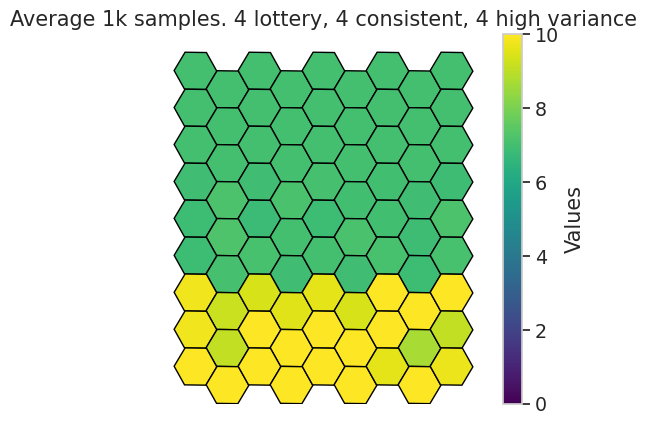

In [14]:
sample_and_plot(dist_N, size=1000, average=True, title='Average 1k samples. 4 lottery, 4 consistent, 4 high variance', vmin=0, vmax=10)

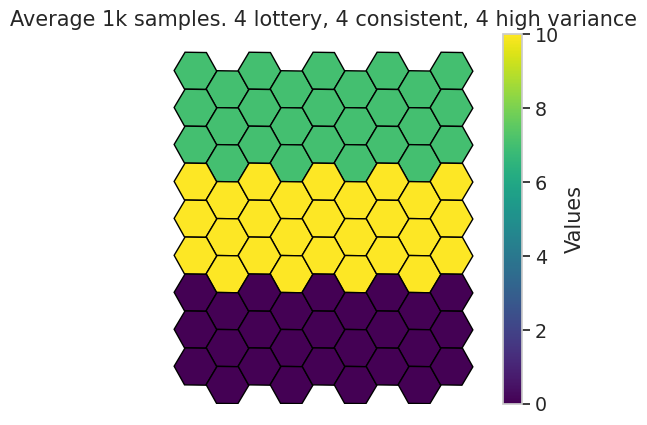

In [15]:
sample_and_plot(dist_N, size=1000, median=True, title='Average 1k samples. 4 lottery, 4 consistent, 4 high variance', vmin=0, vmax=10)

In [49]:
np.argsort(np.argsort(np.sum(winners_MR,axis=1)))
# rank with ties
import scipy
scipy.stats.rankdata(np.sum(winners_MR,axis=1),method='max' )

array([1, 1, 1, 1])

In [17]:
mnames = ['cross_ratio','pick_median', 'pick_mean','guess_random']
R = 10000 
winners = []
for K in range(1,82):
    print(K)
    scores_MR = np.zeros((len(mnames), R))
    for mm, method in enumerate(mnames):
        scores_MR[mm] = calc_bpr_many_trials(
            dist_N, K=K, n_trials=R, strategy=method)
        
    winscore_1R = scores_MR.max(axis=0, keepdims=1)

    winners_MR = np.abs(scores_MR - winscore_1R) < 1e-6

    ranks = scipy.stats.rankdata(np.sum(winners_MR,axis=1),method='max')
    winners.append(ranks)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


In [ ]:
winners_reversed = scipy.stats.rankdata(-np.array(winners),axis=1,method='max')
# Transpose the array to have 4 rows and M columns
transposed_array = winners_reversed.T

# Print the transposed array
for row in transposed_array:
    print("\t".join(map(str, row)))

4	4	4	2	1	1	1	1	1	1	1	1	2	2	2	2	2	2	2	2	4	4	4	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	2	3	3	3	3	3	3	3	4	4	4	4	4	3	3	2	2	2	3	3	3	3	4	4	3	4	4	4	4	4	4	4
1	1	1	1	3	3	3	4	4	4	4	4	4	3	3	3	3	3	3	4	3	3	3	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	4	3	3	3	3	3	4	4	4	3	3	2	2	2	2	1	1	1	1	1	1	1	1	1	4
3	3	3	3	2	2	2	2	2	2	2	2	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	2	3	4	4	4	4	4	4	3	3	4	3	3	3	3	3	3	4
2	2	2	4	4	4	4	3	3	3	3	3	3	4	4	4	4	4	4	3	2	2	2	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	3	2	2	2	2	2	2	2	2	2	2	2	2	2	1	1	1	1	1	1	1	1	2	2	2	2	2	2	2	2	2	4


In [69]:
    print(f'K={K}')
    for mm, mname in enumerate(mnames):
        print("%25s won % 6d/%d trials" % (mname, winners_MR[mm].sum(), R))

K=81
         pick_cross_ratio won  10000/10000 trials
              pick_median won  10000/10000 trials
                pick_mean won  10000/10000 trials
             guess_random won  10000/10000 trials


In [66]:
winscore_1R

array([[1.        , 1.        , 1.        , ..., 0.99221357, 1.        ,
        1.        ]])